# WHAT DRIVES THE HOUSING PRICES?

This study develops several architectural housing features, facilities conditions that are capable of explaining the house prices in the given database. The objective of this study is also to predict the price for each house.

In [1]:
# Importing some libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import time
%matplotlib inline
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

In [2]:
# Importing dataset
df = pd.read_csv('../input/housing.csv', delimiter = ';')

In [3]:
df.head()

,Unnamed: 0,price,lotsize,bedrooms,bathrms,stories,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea
0,1,42000.0,5850,3,1,2,yes,no,yes,no,no,1,no
1,2,38500.0,4000,2,1,1,yes,no,no,no,no,0,no
2,3,49500.0,3060,3,1,1,yes,no,no,no,no,0,no
3,4,60500.0,6650,3,1,2,yes,yes,no,no,no,0,no
4,5,61000.0,6360,2,1,1,yes,no,no,no,no,0,no


In [4]:
# Some informations
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 13 columns):
Unnamed: 0    546 non-null int64
price         546 non-null float64
lotsize       546 non-null int64
bedrooms      546 non-null int64
bathrms       546 non-null int64
stories       546 non-null int64
driveway      546 non-null object
recroom       546 non-null object
fullbase      546 non-null object
gashw         546 non-null object
airco         546 non-null object
garagepl      546 non-null int64
prefarea      546 non-null object
dtypes: float64(1), int64(6), object(6)
memory usage: 55.5+ KB


**Comment**:

As can be seen, this database contains totally 546 observations (rows) of 12 variables (12 columns and the first columns of numerated order). There are no missing values and the types of each variables are listed on the above result, notably, there are 6 variables (driveway, recroom, fullbase, gashw, airco and prefarea) are under data-types of strings (yes/no).

## 1. Exploratory Data Analysis (EDA)

In [4]:
# Dropping `Unnamed: 0` column and performing descriptive statistics
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.describe()

,price,lotsize,bedrooms,bathrms,stories,garagepl
count,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000
mean,68121.597070,5150.265568,2.965201,1.285714,1.807692,0.692308
std,26702.670926,2168.158725,0.737388,0.502158,0.868203,0.861307
min,25000.000000,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,49125.000000,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,62000.000000,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,82000.000000,6360.000000,3.000000,2.000000,2.000000,1.000000
max,190000.000000,16200.000000,6.000000,4.000000,4.000000,3.000000


First of all, I give a table of descriptive database statistics and then in the next part I will analyse each variable and their relationship via both graphic and statistical analysis.

### 1.1.  Predictor variable: `price`

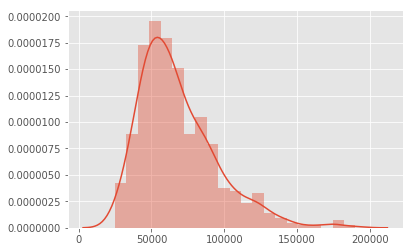

In [7]:
# Distribution of `price`
sns.distplot(df['price'].values)

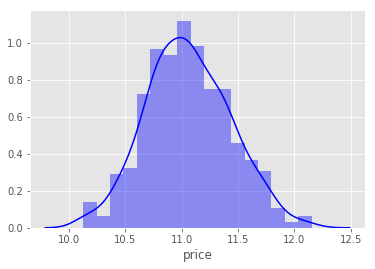

In [8]:
# Distribution of logarithm of `price`
sns.distplot(np.log(df['price']), color = 'blue')

**Comment**:

The house prices in this database ranges from 25.000 to 190.000 while the prices mostly concentrated on the range of 30.000 - 100.000.

Obviously, the histogram show that the house price in this database is non-normally distributed and right-skewed with fat tail while its logarithm seem to exhibit normal distributions. In this study, I choose to consider the logarithm of house price in stead of its own price as its scale is more narrowed in comparing with the ranging scale of price. Taking logs means that errors in predicting expensive house and cheap house will affect the result equally. This may be consistent with the other variables while their ranges scale are quite small, which may lead to better prediction. 

### 1.2. Correlation matrix

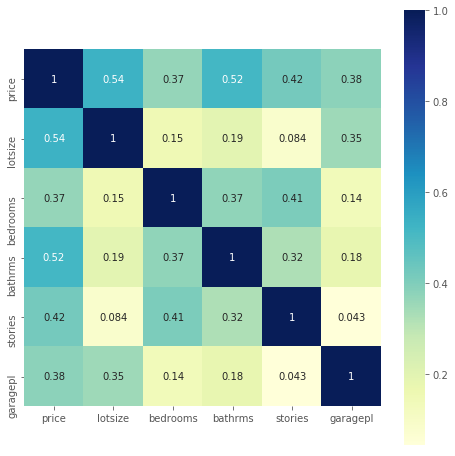

In [9]:
# Perform matrix correlation
corrmat = df.corr()
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corrmat, square = True, annot=True, cmap="YlGnBu");

**Comment:**

Among continuous variables, lotsize and bathrooms are highly positively correlated with housing price with their correlation coefficients of over 0.5, followeed by stories, garagepl and bedroom (nearly 0.4). Therefore, these variables might play an important role in linear regression models (in comparing with non-linear models) which can be considered in the following part below. 

### 1.3. `lotsize` variable and its relationship with `price`

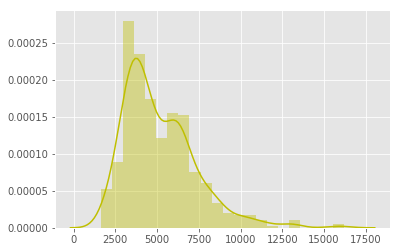

In [10]:
# Considering distribution of `lotsize`
sns.distplot(df['lotsize'].values, color = 'y')

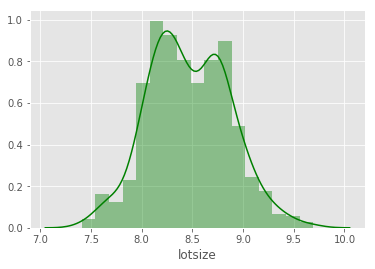

In [11]:
# Considering distribution of the logarithm of `lotsize`
sns.distplot(np.log(df['lotsize']), color = 'g')

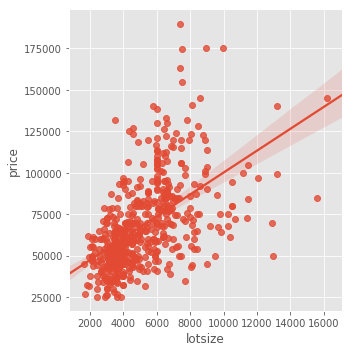

In [12]:
# Scatter plot between `price` and `lotsize`
sns.lmplot(x = 'lotsize', y = 'price', data = df)

**Comment:**

Similarly, the logarithm of lotsizes are employed in our study. The plot between prices and lotsize shows the linear relationship (highly positive covariance). Furthermore, the variance of error is quite high and it may exhibit heteroskedasticity presence (variance of errors|lotsize is not constant).

### 1.4. `bedrooms` variable and its relationship with `price`

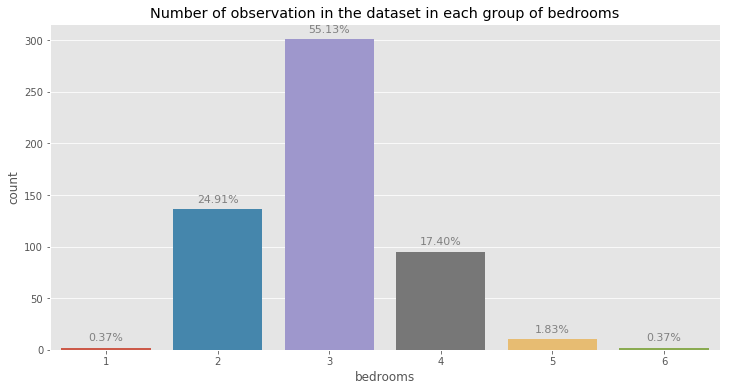

In [13]:
plt.figure(figsize = (12, 6));
g = sns.countplot(x = 'bedrooms', data = df)
plt.title('Number of observation in the dataset in each group of bedrooms');
ax = g.axes
for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / df.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='gray', rotation=0, xytext=(0, 10),
         textcoords='offset points')  

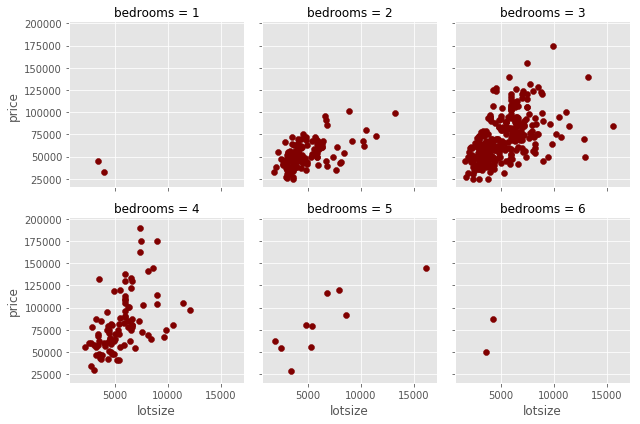

In [14]:
g = sns.FacetGrid(df, col = 'bedrooms', col_wrap = 3, sharex = True, sharey = True)
g.map(plt.scatter, 'lotsize', 'price', color = 'maroon')

**Comment:**

By analysing the ordinary features (categorical variable) of number of bedrooms, house with 3 bedrooms counts for a half of database, followed by 2 and 4 bedrooms (25% and 17%, respectively) while the others are negligible (nearly only 2%).

In each group of bedrooms (mainly houses with 2 - 5 bedrooms), the linear relations are also found between them with the its prices and lotsize.

### 1.5. `bathrms` variable and its relationship with `price`

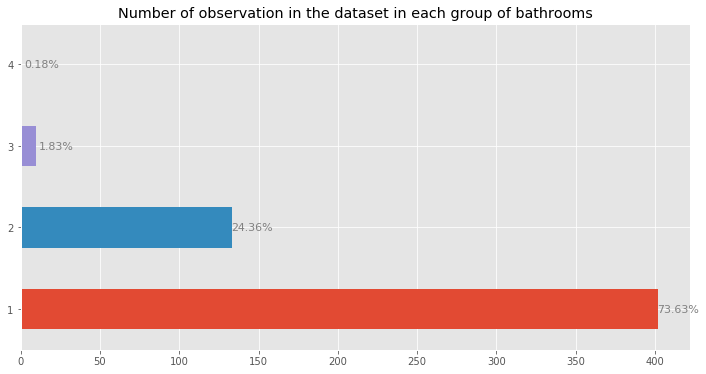

In [15]:
plt.figure(figsize = (12, 6));
df['bathrms'].value_counts().sort_index().plot.barh()
plt.title('Number of observation in the dataset in each group of bathrooms');
ax = plt.gca()
for p in ax.patches:
     ax.annotate(f"{p.get_width() * 100 / df.shape[0]:.2f}%", (p.get_width(), p.get_y() + p.get_height() / 2.),
         ha='center', va='center', fontsize=11, color='gray', rotation=0, xytext=(20, 0),
         textcoords='offset points')  

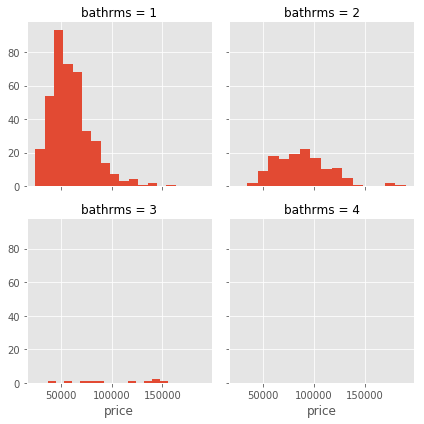

In [16]:
# Perform distribution of `price` in each group of `bathrms`
g = sns.FacetGrid(df, col = 'bathrms', col_wrap = 2, sharex = True, sharey = True)
g.map(plt.hist, 'price', bins = 15)

### 1.6. `stories` variable and its relationship with `price`

In [17]:
df['stories'].value_counts().sort_index()/df.shape[0]*100

1    41.575092
2    43.589744
3     7.326007
4     7.509158
Name: stories, dtype: float64

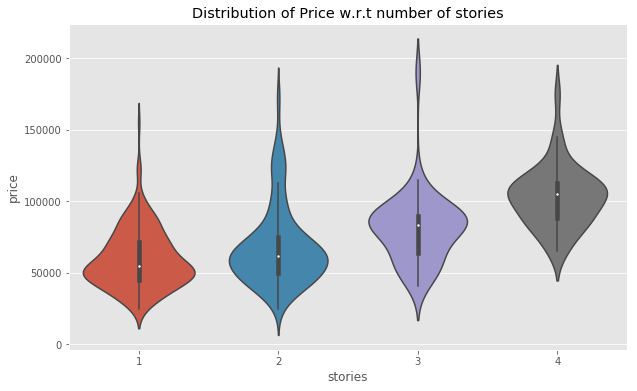

In [19]:
plt.figure(figsize = (10, 6));
sns.violinplot(x = "stories", y = "price", data = df);
plt.title('Distribution of Price w.r.t number of stories');

**Comment:**

The above violin plot illustrates the distribution of house prices in each group divided by number of stories. As can be seen, the more stories are, the higher of (median, mode) prices are. The shape of the distribution indicates that houses with 2 stories are highly concentrated around the median.

### 1.7. `driveway` variable and its relationship with `price`

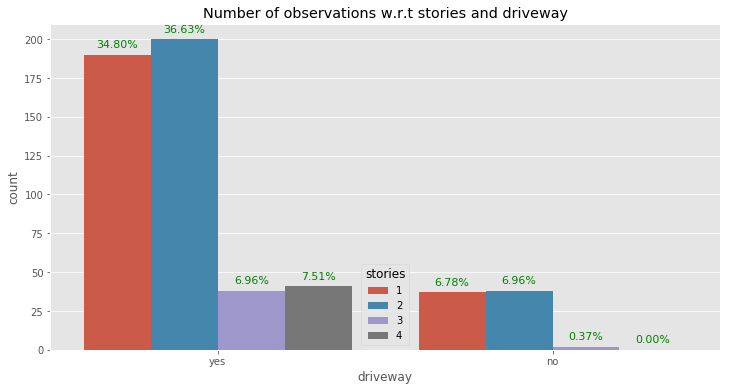

In [20]:
plt.figure(figsize = (12, 6));
g = sns.countplot(x = 'driveway', data = df, hue = 'stories');
plt.title('Number of observations w.r.t stories and driveway');
ax = g.axes
for p in ax.patches:
    h = p.get_height() if str(p.get_height()) != 'nan' else 0 
    ax.annotate(f'{h * 100 / df.shape[0]:.2f}%', (p.get_x() + p.get_width() / 2., h),
             ha='center', va='center', fontsize=11, color = 'green', rotation=0, xytext=(0, 10),
             textcoords='offset points') 

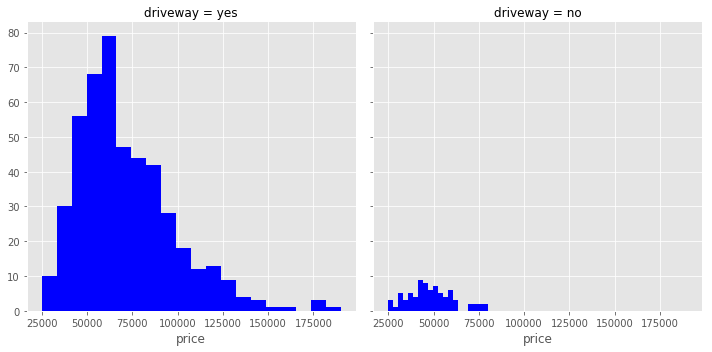

In [21]:
g = sns.FacetGrid(df, col = 'driveway', col_wrap = 2, sharex = True, sharey = True, height=5)
g.map(plt.hist, 'price', color = 'blue', bins = 20)

**Comment:**

Number of houses having a driveway accounts for nearly 85% total database. Obviously, the price ranges of houses without driveway are much more narrowed (under 75000) in comparing with the houses with driveway.

### 1.8. `recroom` variable and its relationship with `price`

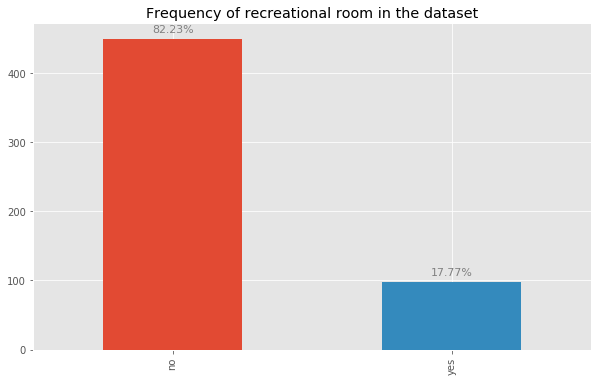

In [22]:
plt.figure(figsize = (10, 6));
df['recroom'].value_counts().sort_index().plot.bar()
plt.title('Frequency of recreational room in the dataset');
ax = plt.gca()
for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / df.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='gray', rotation=0, xytext=(0, 10),
         textcoords='offset points')  

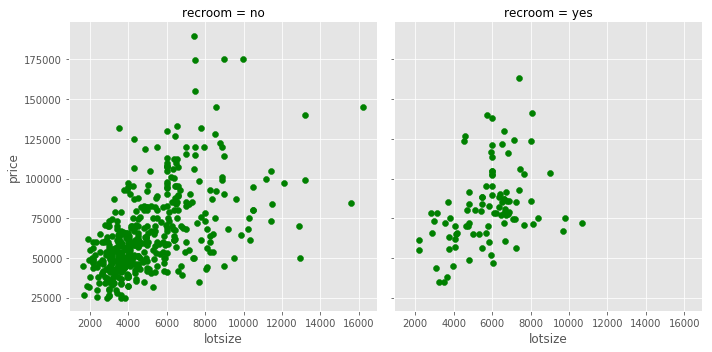

In [23]:
g = sns.FacetGrid(df, col = 'recroom', col_wrap = 2, sharex = True, sharey = True, height=5)
g.map(plt.scatter, 'lotsize', 'price', color = 'green')

**Comment:**

In this part, we consider the relationship among the recreational room existence with house prices and lotsize. We expect that the house equipped with a recreational room may be a large house (high lotsize) and be sold with high prices. However, the result shows the contradictory pattern while most of house with recreational rooms are small and medium (under 10000 of lotsize) and the price is not much high (for this dataset).  

### 1.9. `fullbase` variable and its relationship with `price`

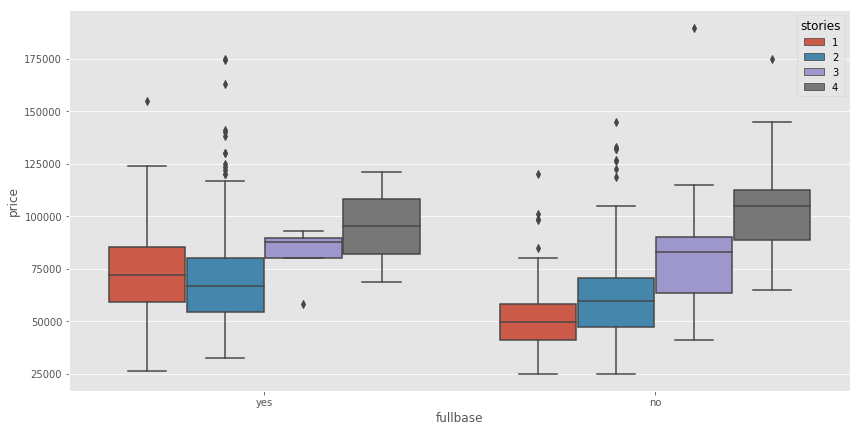

In [24]:
plt.figure(figsize = (14, 7))
ax = plt.gca()
sns.boxplot(x = 'fullbase', y = 'price', hue = 'stories', data = df, ax = ax)

**Comment:**

In this part, we consider the relationship between the fullbase housing situation with price and number of stories. It's also noted that the number of houses with 1 and 2 stories constitute a large part of database (85%) where the median of prices in these group of houses with full basement are higher than groups without basement. However, there are no differences between the median prices in groups of houses with 3 and 4 stories. This unconsistency may be explained by the size of database while the number of observations in 3 or 4 story-houses are quite small. 

### 1.10. `gashw`, `airco` variables and their relationship with `price`

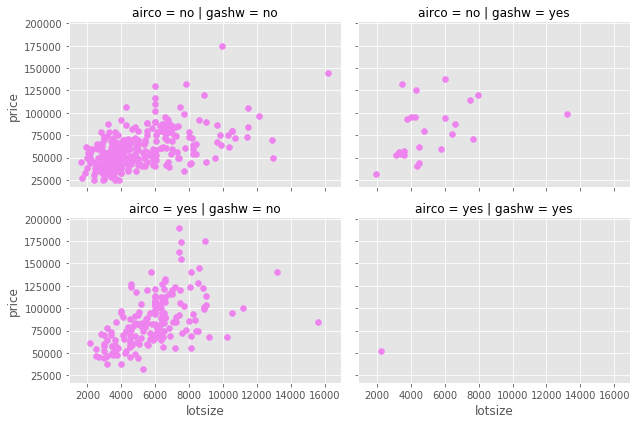

In [25]:
g = sns.FacetGrid(df, col = 'gashw', row = 'airco', sharex = True, sharey = True, height = 3, aspect = 1.5)
g.map(plt.scatter, 'lotsize', 'price', color = 'violet')

**Comment:**

As can be seen, the houses non-equiped with air conditioning and hot water gased-heating makes up a large part of database. Most of housed equiped these facilities concentrated in the groups of houses with small and medium lotsize. In comparing with the house without these facilites, the houses equiped with air conditioning/ hot water gased-heating are sold with higher price. 

### 1.11. `garagepl` variable and its relationship with `price`

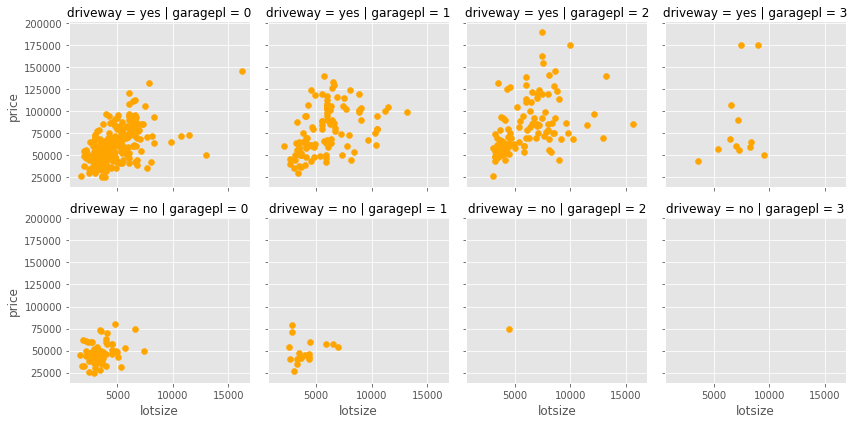

In [26]:
g = sns.FacetGrid(df, col = 'garagepl', row = 'driveway', sharex = True, sharey = True)
g.map(plt.scatter, 'lotsize', 'price', color = 'orange')

**Comment:**

In this part, we consider the relationship among the number places of garage with driveway existence, price and lotsize with the expection that the house with a driveway and large lotsizes has more places in garage, then can be sold with higher price. Obviously, the houses with number of garage places under 1 are mostly small houses with lower prices. Furthermore, the graphes in each group of house with driveway are supported the above ideas while houses with high garage capacity are sold at higher price. 

### 1.12. `prefarea` variable and its relationship with `price`

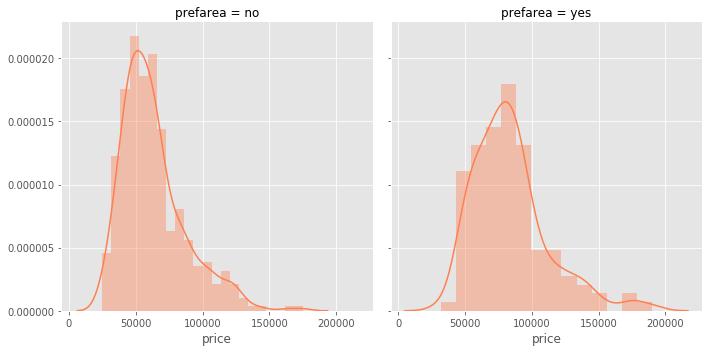

In [28]:
g = sns.FacetGrid(df, col = 'prefarea', sharex = True, sharey = True, height = 5)
g.map(sns.distplot, 'price', color = 'coral')

**Comment:**

The above histograms illustrates the relationship between prices and prefered area location of house. As can be seen, most houses located in the prefered areas have higher median/mode price and right-fat tail. 

## 2. Objective of the study

- **Problem**:
This study develops several architectural housing features, facilities conditions that are capable of explaining the house prices in the given database. The objective of this study is also to predict the price for each house.

- **Evaluation metrics**:
Mean-squared-errors (MSE) metrics between the logarithm of the predicted value and the logarithm of the observed sales house price are employed in this study.

- **Validation method**:
The idea of validation method is to split this database into training and test datasets while test sets account for 20% of database. In the training set, 4-fold cross validation is used to evaluate the models' results. And finally, the house price is predicted on the test sets and then evaluate the results.

- **Models chosen**:
In this study, I tend to use 3 groups of model: basic Neural Network (linear regression with regularization, non-linear ReLU hidden layer), Tree-based models (bagging/boosting ensemble) and Support Vector Machine (different kernels).

## 3. Features engineering

In [29]:
# Taking logarithm
def make_log_features(df):
    df['log_price'] = np.log1p(df['price'])
    df['log_lotsize'] = np.log1p(df['lotsize'])
    return df
df = make_log_features(df)

In [30]:
X = df.drop(['price', 'lotsize', 'log_price'], axis = 1)
Y = df['log_price']

In [31]:
def convert_category_features(df, cat_cols):
    df[cat_cols] = df[cat_cols].astype('category')
    return df

In [32]:
cat_cols = ['driveway', 'recroom', 'fullbase', 'gashw', 'airco', 'prefarea']
cat_idx = [i for i, col in enumerate(X.columns) if col in cat_cols]
X = convert_category_features(X, cat_cols)

In [33]:
# Splitting the training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 167)
X_train.reset_index(drop = True, inplace = True)
Y_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
Y_test.reset_index(drop = True, inplace = True)

In [34]:
#Function of creating dummy variables from categorical variables
def make_one_hot_encoding(train, test, cat_cols):
    one_hot_train = pd.get_dummies(train[cat_cols])
    one_hot_test = pd.get_dummies(test[cat_cols])
    train_one_hot, test_one_hot = one_hot_train.align(one_hot_test, join='left', axis = 1)
    train_x = train.drop(cat_cols, axis = 1)
    test_x = test.drop(cat_cols, axis = 1)
    train_x = pd.concat([train_x, train_one_hot], axis = 1)
    test_x = pd.concat([test_x, test_one_hot], axis = 1)
    return train_x, test_x

In [35]:
#Function of creating label encoding from categorical variables
def make_label_encoding(train, test, cat_cols):
    indexer = {}
    for col in cat_cols:
        _, indexer[col] = pd.factorize(train[col])
    train_x = train.copy()
    test_x = test.copy()
    for col in cat_cols:
        train_x.loc[:, col] = indexer[col].get_indexer(train_x.loc[:, col])
        test_x.loc[:, col] = indexer[col].get_indexer(test_x.loc[:, col])
    return train_x, test_x

In [36]:
#This main function allows to make k-fold CV on training set and predict on the test sets in each model.
def stacking(X, Y, X_test, cv, model_type = 'lgb', model_from_sklearn = Ridge(), one_hot = False, label_encoding = False, params = None, eval_fn = mean_squared_error, plot_feature_importances = False):
    cv_scores = []
    test_pred = np.zeros(len(X_test))
    train_pred = np.zeros(len(X))
    feature_importances = np.zeros(X.shape[1])
    kf = KFold(n_splits = cv, shuffle = True, random_state = 167)
    
    # One hot encoding for Neural Network models:
    if one_hot:
        X, X_test = make_one_hot_encoding(X, X_test, cat_cols)
        
    # Label encoding for Tree-based models:
    if label_encoding:
        X, X_test = make_label_encoding(X, X_test, cat_cols)
    
    # K-Fold Cross-validation:
    for (fold_n, (train_index, val_index)) in enumerate(kf.split(X, Y)):
        gc.collect()
        print('Fold', fold_n + 1, 'started at', time.ctime())
        Y_train, Y_val = Y[train_index], Y[val_index] 
        if isinstance(X, pd.DataFrame):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        else:
            X_train, X_val = X[train_index], X[val_index]
                       
        if model_from_sklearn is not None:
            model = model_from_sklearn
            model.fit(X_train, Y_train)
            if plot_feature_importances:
                feature_importances += model.feature_importances_
            Y_val_pred = model.predict(X_val)
            Y_test_pred = model.predict(X_test)                        
            
        else:    
            if model_type == 'lgb':
                train_data = lgb.Dataset(X_train, label = Y_train, categorical_feature = cat_idx)
                val_data = lgb.Dataset(X_val, label = Y_val, categorical_feature = cat_idx)
                watchlist = [train_data, val_data]
                model = lgb.train(params, train_data, num_boost_round = 1000, valid_sets = watchlist,
                                  verbose_eval = 100, early_stopping_rounds = 100)
                if plot_feature_importances:
                    feature_importances += model.feature_importance()
                Y_val_pred = model.predict(X_val, num_iteration = model.best_iteration)
                Y_test_pred = model.predict(X_test, num_iteration = model.best_iteration)    

            if model_type == 'xgb':
                train_data = xgb.DMatrix(data = X_train, label = Y_train)
                val_data = xgb.DMatrix(data = X_val, label = Y_val)
                watchlist = [(train_data, 'train'), (val_data, 'val')]           
                model = xgb.train(dtrain = train_data, num_boost_round = 2000, evals = watchlist, early_stopping_rounds = 200, 
                                  verbose_eval = 200, params = params)
                if plot_feature_importances:
                    feature_importances += np.array([model.get_score(importance_type = 'total_gain')[col] for col in X.columns])
                Y_val_pred = model.predict(xgb.DMatrix(X_val), ntree_limit = model.best_ntree_limit)
                Y_test_pred = model.predict(xgb.DMatrix(X_test), ntree_limit = model.best_ntree_limit)
            
            if model_type == 'cat':
                train_data = cb.Pool(data = X_train, label = Y_train, cat_features = cat_idx)
                val_data = cb.Pool(data = X_val, label = Y_val, cat_features = cat_idx)
                model = cb.CatBoostRegressor(iterations = 4000, learning_rate = 0.3, od_type = 'Iter', od_wait = 500, 
                                             loss_function = 'RMSE', eval_metric = 'RMSE')
                model.fit(train_data, eval_set = val_data, use_best_model = True, verbose = 500)
                if plot_feature_importances:
                    feature_importances += np.array(model.get_feature_importance())
                Y_val_pred = model.predict(X_val)
                Y_test_pred = model.predict(X_test)
            
        if eval_fn is not None:
            cv_score = eval_fn(Y_val, Y_val_pred)
            print(f'Fold {fold_n + 1} MSE:', cv_score)
            cv_scores.append(cv_score)
        
        train_pred[val_index] = Y_val_pred
        test_pred += Y_test_pred
        
    print(f'{model_type} CV MSE scores: {cv_scores}')
    print(f'{model_type} CV mean MSE score: {np.mean(cv_scores)}')
    print(f'{model_type} CV std MSE score : {np.std(cv_scores)}')
    if plot_feature_importances:
        pd.Series(feature_importances / cv, index = X.columns).sort_values().plot.barh(figsize = (14, 8), title = 'Plot feature importances')
    result_dict = {'Model': model_type, 'scores': cv_scores, 'train_pred': train_pred, 'test_pred': test_pred / cv}
    return result_dict

## 4. Model selection

### 4.1. Linear Regression

In this section, the first model is used is the simplest linear regression, which is employed as a baseline model to evaluate the performance of other model or algorithm used in the following part.

In [37]:
train, test = make_one_hot_encoding(X_train, X_test, cat_cols)

In [38]:
reg = LinearRegression()
reg.fit(train, Y_train)
Y_train_pred = reg.predict(train)
Y_test_pred = reg.predict(test)

In [39]:
# MSE on training set
mean_squared_error(Y_train, Y_train_pred)

0.044469113183847234

In [40]:
# MSE on test set
mean_squared_error(Y_test, Y_test_pred)

0.039298053284391635

**Comment**:

This result in the first linear model is quite impressive while the MSE in the test set is quite small and lower than in the train set. This seems to be consistent with the hypothesis I mentioned in the first part where these variables in this housing database exhibit linear relationship.

In [41]:
# Preparing a dataframe to store the results
results = pd.DataFrame(columns = ['Model', 'MSE_Fold1', 'MSE_Fold2', 'MSE_Fold3', 'MSE_Fold4', 'MSE_Test'])

### 4.2. Ridge Regression (Linear Regression with L2 regularization)

In [42]:
# Tuning hyper-parameters by GridSearchCV
params = {'alpha': [i for i in range(100)]}
reg = GridSearchCV(Ridge(), param_grid = params, cv = 4, scoring = 'neg_mean_squared_error')
reg.fit(train, Y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [43]:
reg.best_params_

{'alpha': 1}

In [44]:
reg.best_score_

-0.04692617288630847

In [45]:
# 4-fold CV with hyper-parameters tuned
result_dict_ridge = stacking(X_train, Y_train, X_test, 4, model_type = 'Ridge', model_from_sklearn = Ridge(alpha = 1), one_hot = True, label_encoding = False, plot_feature_importances = False)

Fold 1 started at Mon Feb 25 08:47:57 2019
Fold 1 MSE: 0.03645639935479851
Fold 2 started at Mon Feb 25 08:47:57 2019
Fold 2 MSE: 0.043718379974736765
Fold 3 started at Mon Feb 25 08:47:57 2019
Fold 3 MSE: 0.05735634442572019
Fold 4 started at Mon Feb 25 08:47:57 2019
Fold 4 MSE: 0.0500706859453043
Ridge CV MSE scores: [0.03645639935479851, 0.043718379974736765, 0.05735634442572019, 0.0500706859453043]
Ridge CV mean MSE score: 0.046900452425139946
Ridge CV std MSE score : 0.007723015727614033


In [46]:
# MSE on test set
Y_test_pred = result_dict_ridge['test_pred']
mean_squared_error(Y_test, Y_test_pred)

0.03911147764310042

In [47]:
# Storing the results
results.loc[len(results), :] = ['Ridge Regression'] + result_dict_ridge['scores'] + [mean_squared_error(Y_test, Y_test_pred)]

### 4.3. Lasso (Linear Regression with L1 regularization)

In [48]:
# Tuning hyper-parameters by GridSearchCV
params = {'alpha': [i for i in np.arange(1, 100)]}
reg = GridSearchCV(Lasso(), param_grid = params, cv = 4, scoring = 'neg_mean_squared_error')
reg.fit(train, Y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [49]:
reg.best_params_

{'alpha': 1}

In [50]:
reg.best_score_

-0.1405588391528471

In [51]:
# 4-fold CV with hyper-parameters tuned
result_dict_lasso = stacking(X_train, Y_train, X_test, 4, model_type = 'Lasso', model_from_sklearn = Lasso(alpha = 1), one_hot = True, label_encoding = False, plot_feature_importances = False)

Fold 1 started at Mon Feb 25 08:48:12 2019
Fold 1 MSE: 0.11775100525355811
Fold 2 started at Mon Feb 25 08:48:12 2019
Fold 2 MSE: 0.14604336025826883
Fold 3 started at Mon Feb 25 08:48:12 2019
Fold 3 MSE: 0.1436743020070724
Fold 4 started at Mon Feb 25 08:48:12 2019
Fold 4 MSE: 0.1532067952772449
Lasso CV MSE scores: [0.11775100525355811, 0.14604336025826883, 0.1436743020070724, 0.1532067952772449]
Lasso CV mean MSE score: 0.14016886569903605
Lasso CV std MSE score : 0.013410311747638575


In [52]:
# MSE on test set
Y_test_pred = result_dict_lasso['test_pred']
mean_squared_error(Y_test, Y_test_pred)

0.13086408689663837

In [53]:
# Storing the results
results.loc[len(results), :] = ['Lasso Regression'] + result_dict_lasso['scores'] + [mean_squared_error(Y_test, Y_test_pred)]

### 4.4. Neural Network (with one hidden layer)

In [56]:
# Tuning hyper-parameters by GridSearchCV
params = {'hidden_layer_sizes': [(i, ) for i in np.arange(40, 100, 10)], 'alpha': [j for j in np.arange(0, 50, 5)]}
reg = GridSearchCV(MLPRegressor(max_iter = 10000), param_grid = params, cv = 4, scoring = 'neg_mean_squared_error')
reg.fit(train, Y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'hidden_layer_sizes': [(40,), (50,), (60,), (70,), (80,), (90,)], 'alpha': [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [57]:
reg.best_params_

{'alpha': 25, 'hidden_layer_sizes': (70,)}

In [58]:
reg.best_score_

-0.05225460722661186

In [59]:
# 4-fold CV with hyper-parameters tuned
result_dict_nn = stacking(X_train, Y_train, X_test, 4, model_type = 'Neural Network', model_from_sklearn = MLPRegressor(hidden_layer_sizes = (75, ), alpha = 25, max_iter = 10000), one_hot = True, label_encoding = False, plot_feature_importances = False)

Fold 1 started at Mon Feb 25 09:01:06 2019
Fold 1 MSE: 0.042426400254511706
Fold 2 started at Mon Feb 25 09:01:08 2019
Fold 2 MSE: 0.04601094962065871
Fold 3 started at Mon Feb 25 09:01:10 2019
Fold 3 MSE: 0.06408031620536689
Fold 4 started at Mon Feb 25 09:01:12 2019
Fold 4 MSE: 0.0593679062385518
Neural Network CV MSE scores: [0.042426400254511706, 0.04601094962065871, 0.06408031620536689, 0.0593679062385518]
Neural Network CV mean MSE score: 0.05297139307977228
Neural Network CV std MSE score : 0.008999558328511518


In [60]:
# MSE on test set
Y_test_pred = result_dict_nn['test_pred']
mean_squared_error(Y_test, Y_test_pred)

0.045011039317423826

In [61]:
# Storing the results
results.loc[len(results), :] = ['Neural Network'] + result_dict_nn['scores'] + [mean_squared_error(Y_test, Y_test_pred)]

### 4.5. Random Forest

In [62]:
# Label encoding is likely used to Tree-based models
train, test = make_label_encoding(X_train, X_test, cat_cols)

In [63]:
# Preparing hyper-parameters for tuning
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 50)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(3, 30, num = 3)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [64]:
# Tuning hyper-parameters by RandomizedSearchCV
reg = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = random_grid, n_iter = 200, cv = 4, scoring = 'neg_mean_squared_error', verbose=2, random_state = 167, n_jobs = -1)
reg.fit(train, Y_train)

Fitting 4 folds for each of 200 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  1.3min finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=200, n_jobs=-1,
          param_distributions={'n_estimators': [100, 118, 136, 155, 173, 191, 210, 228, 246, 265, 283, 302, 320, 338, 357, 375, 393, 412, 430, 448, 467, 485, 504, 522, 540, 559, 577, 595, 614, 632, 651, 669, 687, 706, 724, 742, 761, 779, 797, 816, 834, 853, 871, 889, 908, 926, 944, 963, 981, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [3, 16, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_di

In [65]:
reg.best_params_

{'n_estimators': 559,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 16,
 'bootstrap': True}

In [66]:
reg.best_score_

-0.0523374283079894

Fold 1 started at Mon Feb 25 09:03:19 2019
Fold 1 MSE: 0.03599757759338028
Fold 2 started at Mon Feb 25 09:03:19 2019
Fold 2 MSE: 0.05246478907453413
Fold 3 started at Mon Feb 25 09:03:19 2019
Fold 3 MSE: 0.0599243216744196
Fold 4 started at Mon Feb 25 09:03:20 2019
Fold 4 MSE: 0.05335205601933528
Random Forest CV MSE scores: [0.03599757759338028, 0.05246478907453413, 0.0599243216744196, 0.05335205601933528]
Random Forest CV mean MSE score: 0.05043468609041732
Random Forest CV std MSE score : 0.008819235379281134


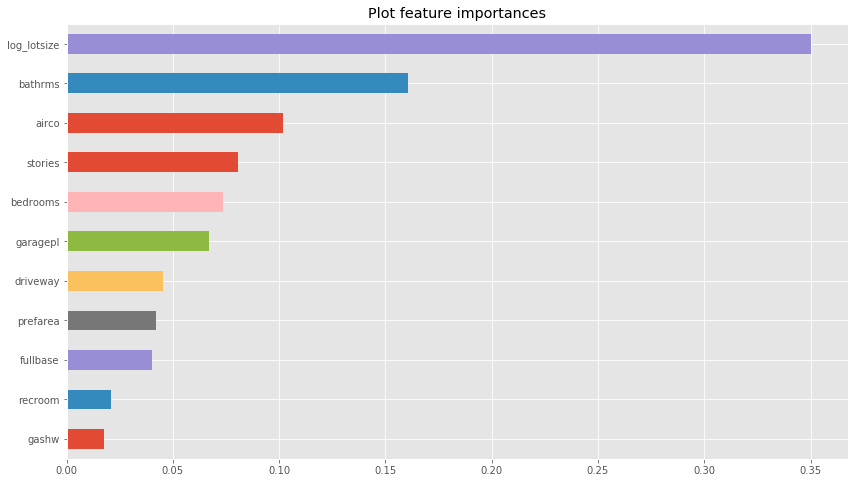

In [67]:
# 4-fold CV with hyper-parameters tuned
result_dict_rf = stacking(X_train, Y_train, X_test, 4, model_type = 'Random Forest', model_from_sklearn = RandomForestRegressor(n_estimators = 559, min_samples_split = 10, min_samples_leaf = 1, max_features = 'sqrt', max_depth = 16, bootstrap = True), one_hot = False, label_encoding = True, plot_feature_importances = True)

In [68]:
# MSE on test set
Y_test_pred = result_dict_rf['test_pred']
mean_squared_error(Y_test, Y_test_pred)

0.041106999613068074

In [69]:
# Storing the results
results.loc[len(results), :] = ['Random Forest'] + result_dict_rf['scores'] + [mean_squared_error(Y_test, Y_test_pred)]

### 4.6. Gradient Boosting

In [70]:
# Preparing hyper-parameters for tuning
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 50)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(3, 30, num = 3)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [71]:
# Tuning hyper-parameters by RandomizedSearchCV
reg = RandomizedSearchCV(estimator = GradientBoostingRegressor(), param_distributions = random_grid, n_iter = 200, cv = 4, scoring = 'neg_mean_squared_error', verbose=2, random_state = 167, n_jobs = -1)
reg.fit(train, Y_train)

Fitting 4 folds for each of 200 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:   37.7s finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=200, n_jobs=-1,
          param_distributions={'n_estimators': [100, 118, 136, 155, 173, 191, 210, 228, 246, 265, 283, 302, 320, 338, 357, 375, 393, 412, 430, 448, 467, 485, 504, 522, 540, 559, 577, 595, 614, 632, 651, 669, 687, 706, 724, 742, 761, 779, 797, 816, 834, 853, 871, 889, 908, 926, 944, 963, 981, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [3, 16, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', rando

In [72]:
reg.best_params_

{'n_estimators': 118,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 3}

In [73]:
reg.best_score_

-0.050771906223292515

Fold 1 started at Mon Feb 25 09:04:26 2019
Fold 1 MSE: 0.03763556072956002
Fold 2 started at Mon Feb 25 09:04:26 2019
Fold 2 MSE: 0.05038981319526787
Fold 3 started at Mon Feb 25 09:04:26 2019
Fold 3 MSE: 0.056644030998000534
Fold 4 started at Mon Feb 25 09:04:26 2019
Fold 4 MSE: 0.048388249446401535
Gradient Boosting CV MSE scores: [0.03763556072956002, 0.05038981319526787, 0.056644030998000534, 0.048388249446401535]
Gradient Boosting CV mean MSE score: 0.04826441359230749
Gradient Boosting CV std MSE score : 0.006850605079749383


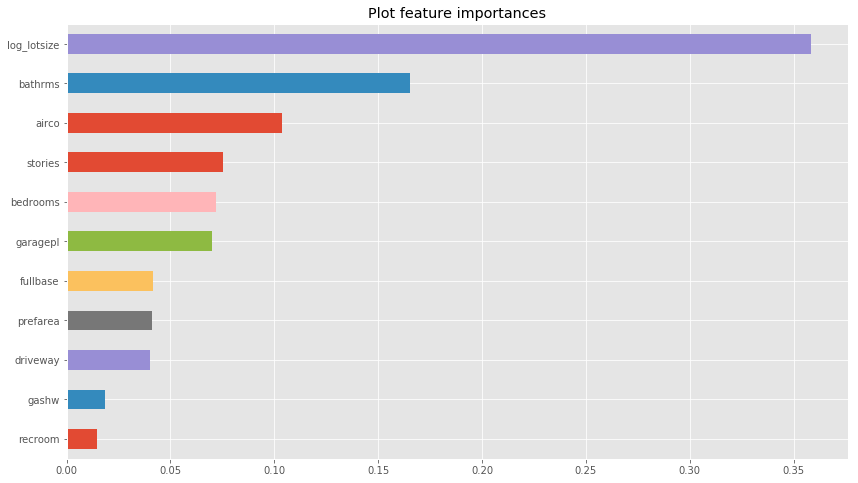

In [74]:
# 4-fold CV with hyper-parameters tuned
result_dict_gb = stacking(X_train, Y_train, X_test, 4, model_type = 'Gradient Boosting', model_from_sklearn = GradientBoostingRegressor(n_estimators = 118, min_samples_split = 10, min_samples_leaf = 2, max_features = 'sqrt', max_depth = 3), one_hot = False, label_encoding = True, plot_feature_importances = True)

In [75]:
# MSE on test set
Y_test_pred = result_dict_gb['test_pred']
mean_squared_error(Y_test, Y_test_pred)

0.04053262754967622

In [76]:
# Storing the results
results.loc[len(results), :] = ['Gradient Boosting'] + result_dict_gb['scores'] + [mean_squared_error(Y_test, Y_test_pred)]

### 4.7. Support Vector Machine

In [77]:
# Tuning hyper-parameters by GridSearchCV
params = {'kernel': ['linear', 'rbf'],
          'gamma': ['auto', 'scale'],
          'C': [1, 10, 30, 60, 100]}
reg = GridSearchCV(SVR(), param_grid = params, cv = 4, scoring = 'neg_mean_squared_error')
reg.fit(train, Y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ['linear', 'rbf'], 'gamma': ['auto', 'scale'], 'C': [1, 10, 30, 60, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [78]:
reg.best_params_

{'C': 60, 'gamma': 'auto', 'kernel': 'linear'}

In [79]:
reg.best_score_

-0.04672818171870636

In [80]:
# 4-fold CV with hyper-parameters tuned
result_dict_svr = stacking(X_train, Y_train, X_test, 4, model_type = 'SVM', model_from_sklearn = SVR(C = 60, gamma = 'auto', kernel = 'linear'), one_hot = False, label_encoding = True, plot_feature_importances = False)

Fold 1 started at Mon Feb 25 09:04:52 2019
Fold 1 MSE: 0.03609004940726028
Fold 2 started at Mon Feb 25 09:04:52 2019
Fold 2 MSE: 0.04373028521133582
Fold 3 started at Mon Feb 25 09:04:52 2019
Fold 3 MSE: 0.05876758270446281
Fold 4 started at Mon Feb 25 09:04:52 2019
Fold 4 MSE: 0.05023871488079982
SVM CV MSE scores: [0.03609004940726028, 0.04373028521133582, 0.05876758270446281, 0.05023871488079982]
SVM CV mean MSE score: 0.04720665805096468
SVM CV std MSE score : 0.008344346938505786


In [81]:
# MSE on test set
Y_test_pred = result_dict_svr['test_pred']
mean_squared_error(Y_test, Y_test_pred)

0.03892284175401074

In [82]:
# Storing the results
results.loc[len(results), :] = ['Support Vector Machine'] + result_dict_svr['scores'] + [mean_squared_error(Y_test, Y_test_pred)]

### 4.8. Light GBM

In [83]:
# Tuning hyper-parameters by GridSearchCV
param_grid = {'max_depth': [int(x) for x in np.linspace(3, 30, 3)],
              'num_leaves': [int(x) for x in np.arange(10, 100, 10)],
              'min_child_weight': [i/100 for i in np.arange(1, 300, 50)],
              'lambda': [1e-2, 0.1, 1, 100]}
reg = GridSearchCV(estimator = lgb.LGBMRegressor(metric = 'mse', learning_rate = 0.1, n_estimators = 200, feature_fraction = 0.8, 
                                                 bagging_fraction = 0.8), param_grid = param_grid, 
                                                 scoring = 'neg_mean_squared_error', n_jobs = -1, iid = False, cv = 4)
reg.fit(train, Y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=LGBMRegressor(bagging_fraction=0.8, boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, feature_fraction=0.8, importance_type='split',
       learning_rate=0.1, max_depth=-1, metric='mse', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=200,
       n_jobs=-1, num_leaves=31, objective=None, random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'max_depth': [3, 16, 30], 'num_leaves': [10, 20, 30, 40, 50, 60, 70, 80, 90], 'min_child_weight': [0.01, 0.51, 1.01, 1.51, 2.01, 2.51], 'lambda': [0.01, 0.1, 1, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [84]:
reg.best_params_

{'lambda': 100, 'max_depth': 3, 'min_child_weight': 0.01, 'num_leaves': 10}

In [85]:
reg.best_score_

-0.05244132178403585

Fold 1 started at Mon Feb 25 09:05:44 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 0.0478736	valid_1's l2: 0.0382332
[200]	training's l2: 0.0441745	valid_1's l2: 0.0368174
Early stopping, best iteration is:
[183]	training's l2: 0.0441745	valid_1's l2: 0.0368174
Fold 1 MSE: 0.03681744655364049
Fold

D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


 2 started at Mon Feb 25 09:05:44 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 0.0431089	valid_1's l2: 0.05115
[200]	training's l2: 0.039944	valid_1's l2: 0.0500344
Early stopping, best iteration is:
[166]	training's l2: 0.0399657	valid_1's l2: 0.0500113
Fold 2 MSE: 0.050011363611745026
Fold 3 started at Mon Feb 25 09:05:44 2019


D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 0.040583	valid_1's l2: 0.0623281
[200]	training's l2: 0.0368176	valid_1's l2: 0.0596996
Early stopping, best iteration is:
[186]	training's l2: 0.0368238	valid_1's l2: 0.0596621
Fold 3 MSE: 0.05966208006764102
Fold 4 started at Mon Feb 25 09:05:45 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 0.0440923	valid_1's l2: 0.0569393
[200]	training's l2: 0.0405666	valid_1's l2: 0.0524905
Early stopping, best iteration is:
[174]	training's l2: 0.0405666	valid_1's l2: 0.0524905
Fold 4 MSE: 0.05249048604096685
lgb CV MSE scores: [0.03681744655364049, 0.050011363611745026, 0.05966208006764102, 0.05249048604096685]
lgb CV mean MSE score: 0.04974534406849834
lgb CV std MSE score : 0.008262547395896703


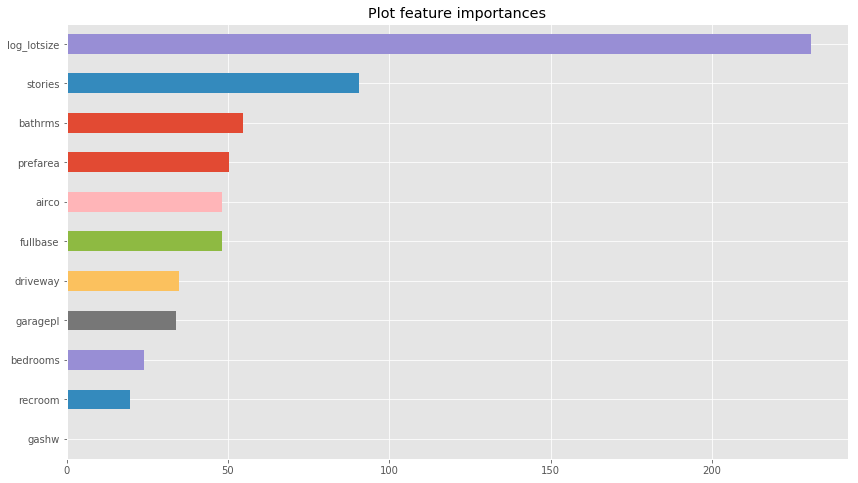

In [86]:
# 4-fold CV with hyper-parameters tuned
params = {'application': 'regression',
          'learning_rate': 0.1,
          'boosting': 'gbdt',
          'metric': 'mse',
          'num_leaves': 10,
          'max_depth': 3,
          'bagging_fraction': 0.8,
          'feature_fraction': 0.8,
          'min_split_gain': 0.01,
          'min_child_weight': 0.01,
          'lambda_l2': 100,
          'verbosity': -1,
          'data_random_seed': 17}
result_dict_lgb = stacking(X_train, Y_train, X_test, 4, model_type = 'lgb', model_from_sklearn = None, one_hot = False, label_encoding = False, params = params, plot_feature_importances = True)

In [87]:
# MSE on test set
Y_test_pred = result_dict_lgb['test_pred']
mean_squared_error(Y_test, Y_test_pred)

0.04285888002404243

In [88]:
# Storing the results
results.loc[len(results), :] = ['Light GBM'] + result_dict_lgb['scores'] + [mean_squared_error(Y_test, Y_test_pred)]

### 4.9. XGBoost

In [89]:
# Tuning hyper-parameters by GridSearchCV
param_grid = {'max_depth': [int(x) for x in np.linspace(3, 30, 3)],
              'min_child_weight': [1, 3, 5],
              'subsample': [i/10.0 for i in range(6, 10)],
              'lambda': [1e-2, 0.1, 1, 100]}
reg = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate = 0.1, n_estimators = 200, colsample_bytree = 0.8, objective= 'reg:linear', 
                                            nthread = 4, scale_pos_weight = 1, seed = 27), param_grid = param_grid, scoring = 'neg_mean_squared_error',
                                            n_jobs = -1, iid = False, cv = 4)
reg.fit(train, Y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=1),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'max_depth': [3, 16, 30], 'min_child_weight': [1, 3, 5], 'subsample': [0.6, 0.7, 0.8, 0.9], 'lambda': [0.01, 0.1, 1, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [90]:
reg.best_params_

{'lambda': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.9}

In [91]:
reg.best_score_

-0.054252200558243674

Fold 1 started at Mon Feb 25 09:06:32 2019
[09:06:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:10.3432	val-rmse:10.3691
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[09:06:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[09:06:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[09:06:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[09:06:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[09:06:32] C:\Users\Admi

[09:06:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[09:06:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[09:06:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:06:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:06:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[09:06:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[09:06:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[09:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[09:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[09:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[09:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[09:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

Fold 1 MSE: 0.03710681807853217
Fold 2 started at Mon Feb 25 09:06:33 2019
[09:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:10.3487	val-rmse:10.3518
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[09:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[09:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[09:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[09:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max

[09:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[09:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[09:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[09:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[09:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[09:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[09:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[09:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[09:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[09:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[09:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

Fold 2 MSE: 0.0493113270680818
Fold 3 started at Mon Feb 25 09:06:34 2019
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:10.3573	val-rmse:10.3256
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_d

[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

Fold 3 MSE: 0.05607717983239646
Fold 4 started at Mon Feb 25 09:06:34 2019
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:10.3495	val-rmse:10.3516
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_

[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[400]	train-rmse:0.166039	val-rmse:0.217785
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\

[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[09:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

Fold 4 MSE: 0.04635963200742684
xgb CV MSE scores: [0.03710681807853217, 0.0493113270680818, 0.05607717983239646, 0.04635963200742684]
xgb CV mean MSE score: 0.04721373924660932
xgb CV std MSE score : 0.0068161537607421665


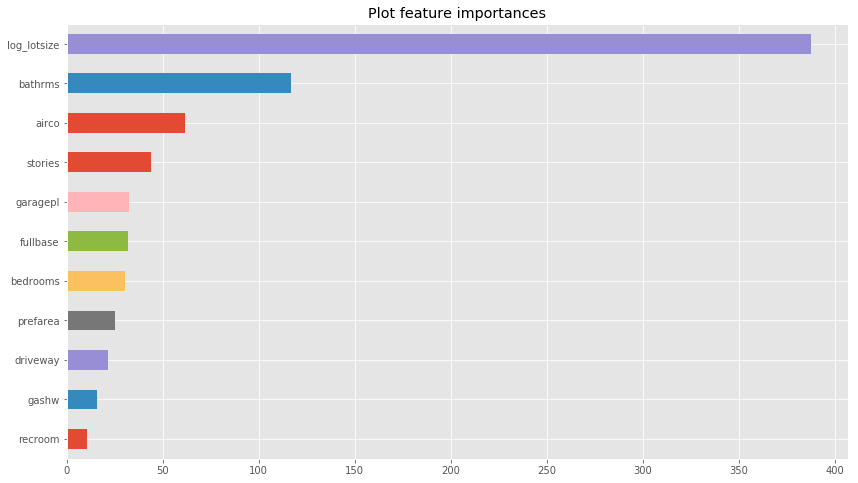

In [92]:
# 4-fold CV with hyper-parameters tuned
params = {'eta': 0.02, 'max_depth': 3, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 3, 'lambda': 0.01,
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'verbosity': 0}
result_dict_xgb = stacking(X_train, Y_train, X_test, 4, model_type = 'xgb', model_from_sklearn = None, one_hot = False, label_encoding = True, params = params, plot_feature_importances = True)

In [93]:
# MSE on test set
Y_test_pred = result_dict_xgb['test_pred']
mean_squared_error(Y_test, Y_test_pred)

0.03983517854613037

In [94]:
# Storing the results
results.loc[len(results), :] = ['XGBoost'] + result_dict_xgb['scores'] + [mean_squared_error(Y_test, Y_test_pred)]

### 4.10. Cat Boost

Fold 1 started at Mon Feb 25 09:06:45 2019
0:	learn: 7.8393302	test: 7.8599455	best: 7.8599455 (0)	total: 78ms	remaining: 5m 11s
500:	learn: 0.2140743	test: 0.2417162	best: 0.2388425 (438)	total: 4.1s	remaining: 28.7s
1000:	learn: 0.2016049	test: 0.2385279	best: 0.2377972 (923)	total: 8.71s	remaining: 26.1s
1500:	learn: 0.1895289	test: 0.2400907	best: 0.2372267 (1089)	total: 13.8s	remaining: 23s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2372267155
bestIteration = 1089

Shrink model to first 1090 iterations.
Fold 1 MSE: 0.056276519314658956
Fold 2 started at Mon Feb 25 09:07:00 2019
0:	learn: 7.8420271	test: 7.8510748	best: 7.8510748 (0)	total: 17.3ms	remaining: 1m 9s
500:	learn: 0.2089847	test: 0.3011029	best: 0.3007665 (412)	total: 4.64s	remaining: 32.4s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.300766477
bestIteration = 412

Shrink model to first 413 iterations.
Fold 2 MSE: 0.09046049253471938
Fold 3 started at Mon Feb 25 09:07:09

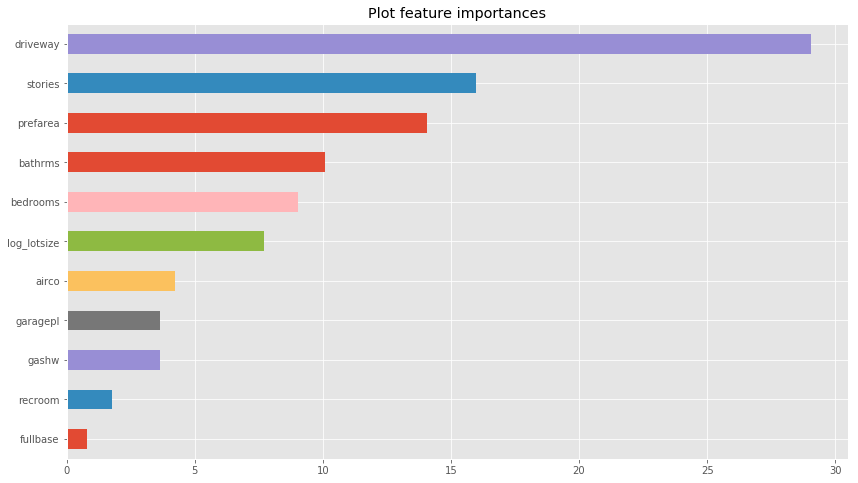

In [95]:
# 4-fold CV with hyper-parameters chosen
result_dict_cb = stacking(X_train, Y_train, X_test, 4, model_type = 'cat', model_from_sklearn = None, one_hot = False, label_encoding = False, params = None, plot_feature_importances = True)

**Comment:**

The last algorithm I try to apply in this database is called CatBoost - A new machine learning library which allows to handle categorical data automatically (without having to label encode or one-hot encode) while the database comprises several variables under yes/no values.

However, the result seems to be not good as expected. One of reason to explain this failure is that in this model, tuning parameters are not implemented at first part.

In [96]:
# MSE on test set
Y_test_pred = result_dict_cb['test_pred']
mean_squared_error(Y_test, Y_test_pred)

0.07412003972317757

In [97]:
# Storing the results
results.loc[len(results), :] = ['CatBoost'] + result_dict_cb['scores'] + [mean_squared_error(Y_test, Y_test_pred)]

### 4.11. Model comparison

In [98]:
results['Mean_MSE_Train'] = np.mean(results.iloc[:, 1:5], axis = 1)

In [99]:
# Performing final results
results

,Model,MSE_Fold1,MSE_Fold2,MSE_Fold3,MSE_Fold4,MSE_Test,Mean_MSE_Train
0,Ridge Regression,0.0364564,0.0437184,0.0573563,0.0500707,0.0391115,0.046900
1,Lasso Regression,0.117751,0.146043,0.143674,0.153207,0.130864,0.140169
2,Neural Network,0.0424264,0.0460109,0.0640803,0.0593679,0.045011,0.052971
3,Random Forest,0.0359976,0.0524648,0.0599243,0.0533521,0.041107,0.050435
4,Gradient Boosting,0.0376356,0.0503898,0.056644,0.0483882,0.0405326,0.048264
5,Support Vector Machine,0.03609,0.0437303,0.0587676,0.0502387,0.0389228,0.047207
6,Light GBM,0.0368174,0.0500114,0.0596621,0.0524905,0.0428589,0.049745
7,XGBoost,0.0371068,0.0493113,0.0560772,0.0463596,0.0398352,0.047214
8,CatBoost,0.0562765,0.0904605,0.0899191,0.0788844,0.07412,0.078885


## 5. Conclusion

- In each model, cross-validation (by using k-fold strategies) are employed to reduces the over-fitting problem in model selection (reduce but not completely overcome this problem), especially, if the size of dataset is quite small like this database (~550 observations). Obviously, it can be seen that the deviation between mean of MSE in 4-folds on train set and it on test set are negligibly small, this can be concluded that the over-fitting problems are reduced in these models. This can be explained by the fact that the train and test sets have same distribution as I splitted them from a dataframe.

- In detail, group of linear models including Linear Regression, Ridge Regression, Support Vector Machine (linear kernel) give better performances in both train and test sets, following by Neural Network (with one hidden layers) model and Tree-based models like Random Forest, Gradient Booosting, XGBoost, Light GBM. In CatBoost, the result seems not to be good in comparing with several linear models.

- As mentioned in above barcharts representing features' participations in models, lotsize plays the most important role in almost models, following by bathroom, stories and air conditionning with modest proportion. This is consistent to high correlations of these variables with the price showed in the first part of database descriptive analysis.

- With better performances associated with the simplity and high-running-speed, the linear models is likely to deploy in virtual reality, especially while the size of database explodes.